In [1]:
import math
import time
from multiprocessing import Pool
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import show_traces
from pyloric.utils import energy_of_membrane, energy_of_synapse
from stg_energy import check_if_close_to_obs 
from sbi.analysis import ActiveSubspace
from sbi.utils import BoxUniform
from stg_energy.common import get_labels_8pt, generate_labels_for_pairplot
from sbi.analysis import pairplot
from pyloric import create_prior
import matplotlib.patheffects as pe

from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin
import stg_energy.fig5_global.viz_05_appendix as viz

# Figure 5

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A1 = "../svg/panel_a1.svg"
PANEL_A2 = "../svg/panel_a2.svg"
PANEL_A3 = "../svg/panel_a3.svg"
PANEL_B1 = "../svg/panel_b1.svg"
PANEL_B2 = "../svg/panel_b2.svg"
PANEL_C1 = "../svg/panel_c1.svg"
PANEL_C2 = "../svg/panel_c2.svg"
PANEL_D11 = "../svg/panel_d11.svg"
PANEL_D12 = "../svg/panel_d12.svg"
PANEL_D21 = "../svg/panel_d21.svg"
PANEL_D22 = "../svg/panel_d22.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_E3 = "../svg/panel_e3.svg"
PANEL_E4 = "../svg/panel_e4.svg"
PANEL_F = "../svg/panel_f.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [7]:
syns = deepcopy(theta_np[:, -7:])
syns = np.exp(syns)

In [8]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [9]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [10]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'
    
posterior._prior = BoxUniform(posterior._prior.support.base_constraint.lower_bound, posterior._prior.support.base_constraint.upper_bound)
posterior._sample_with = "rejection"

/home/michael/Documents/STG_energy_sbi/sbi/inference/posteriors/base_posterior.py:1089: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [11]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [12]:
energies = x["energies"]
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

In [13]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T

### Load experimental data for time vector

In [14]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]
time_vec = np.arange(0, 11000, 0.025)

In [15]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000

In [16]:
allowed_std = 1.0

### Correlation plots

In [17]:
from scipy import stats

In [18]:
ab_energies = x['energies'].to_numpy()[:, 0] / 10 / 1000
lp_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000
py_energies = x['energies'].to_numpy()[:, 2] / 10 / 1000

In [19]:
def eval_reg(point, slope, intercept):
    return point * slope + intercept

slope -0.00346070846487834
pvalue 0.23277554552344074
pearson corr -0.006294416425445372


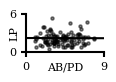

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ab_energies, lp_energies)
pcc = stats.pearsonr(ab_energies, lp_energies)[0]

print("slope", slope)
print("pvalue", p_value)
print("pearson corr", pcc)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 0.5))
    ax.scatter(ab_energies[:100], lp_energies[:100], color="k", s=5.0, alpha=0.5)
    ax.plot([0.0, 9.0], [eval_reg(0.0, slope, intercept), eval_reg(9.0, slope, intercept)], color="k", alpha=1.0)
    ax.set_xlim([0.0, 9.0])
    ax.set_ylim([0.0, 6.0])
    ax.set_xticks([0.0, 9.0])
    ax.set_yticks([0.0, 6.0])
    ax.set_xlabel("AB/PD", labelpad=-7)
    ax.set_ylabel("LP", labelpad=-7)
    plt.savefig(PANEL_A1, facecolor="None", transparent=True)

slope 0.08289654806454937
pvalue 3.3953158768129804e-06
pearson corr 0.024500987310043625


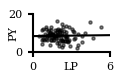

In [21]:
slope, intercept, r_value, p_value, std_err = stats.linregress(lp_energies, py_energies)
pcc = stats.pearsonr(lp_energies, py_energies)[0]

print("slope", slope)
print("pvalue", p_value)
print("pearson corr", pcc)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 0.5))
    ax.scatter(lp_energies[:100], py_energies[:100], color="k", s=5.0, alpha=0.5)
    ax.plot([0.0, 6.0], [eval_reg(0.0, slope, intercept), eval_reg(6.0, slope, intercept)], color="k", alpha=1.0)
    ax.set_xlim([0.0, 6.0])
    ax.set_ylim([0.0, 20.0])
    ax.set_xticks([0.0, 6.0])
    ax.set_yticks([0.0, 20.0])
    ax.set_xlabel("LP", labelpad=-7)
    ax.set_ylabel("PY", labelpad=-7)
    plt.savefig(PANEL_A2, facecolor="None", transparent=True)

slope -0.056543692085396315
pvalue 8.236325194119344e-09
pearson corr -0.030396372515078693


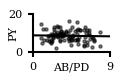

In [22]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ab_energies, py_energies)
pcc = stats.pearsonr(ab_energies, py_energies)[0]

print("slope", slope)
print("pvalue", p_value)
print("pearson corr", pcc)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 0.5))
    ax.scatter(ab_energies[:100], py_energies[:100], color="k", s=5.0, alpha=0.5)
    ax.plot([0.0, 20.0], [eval_reg(0.0, slope, intercept), eval_reg(20.0, slope, intercept)], color="k", alpha=1.0)
    ax.set_xlim([0.0, 9.0])
    ax.set_ylim([0.0, 20.0])
    ax.set_xticks([0.0, 9.0])
    ax.set_yticks([0.0, 20.0])
    ax.set_xlabel("AB/PD", labelpad=-7)
    ax.set_ylabel("PY", labelpad=-7)
    plt.savefig(PANEL_A3, facecolor="None", transparent=True)

### Panel B

In [23]:
preparation = "082"
xo, min_num_bursts = viz.load_xo_minnumbursts_of_preparation(preparation)

In [24]:
selected_ones_1 = [2, 0, 1]
selected_ones_2 = [4, 2, 2]
index_1 = 4
index_2 = 0

successful_seeds (7,)
successful_seeds (1,)


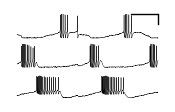

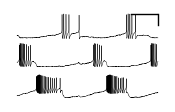

In [25]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_stuff(preparation, selected_ones_1, time_vec, time_len, allowed_std, width=2.0, height=1.2, offset=215000, index=index_1)
    plt.savefig(PANEL_B1, facecolor="None", transparent=True)
    viz.plot_stuff(preparation, selected_ones_2, time_vec, time_len, allowed_std, width=2.0, height=1.2, offset=95000, index=index_2)
    plt.savefig(PANEL_B2, facecolor="None", transparent=True)

### Panel C

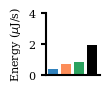

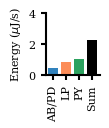

In [26]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    summed_energies_total1 = viz.plot_energies(preparation, selected_ones_1, allowed_std, labels=False, index=index_1)
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    summed_energies_total2 = viz.plot_energies(preparation, selected_ones_2, allowed_std, index=index_2)
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)

### Panel D

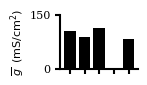

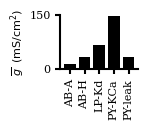

In [27]:
params_to_plot = [3, 6, 13, 20, 23, 24, 27]

samples1, stats, all_seeds_loaded = viz.load_theta_x_seeds(*selected_ones_1, preparation=preparation)
close_sim = check_if_close_to_obs(stats, xo=xo, min_num_bursts=min_num_bursts, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
successful_samples1 = samples1[close_sim][index_1]
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_params(successful_samples1, params_to_plot, labels=False, width=1.0, height=0.7, labelpad=2)
    plt.savefig(PANEL_D11, facecolor='None', transparent=True)

samples2, stats, all_seeds_loaded = viz.load_theta_x_seeds(*selected_ones_2, preparation=preparation)
close_sim = check_if_close_to_obs(stats, xo=xo, min_num_bursts=min_num_bursts, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
successful_samples2 = samples2[close_sim][index_2]
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_params(successful_samples2, params_to_plot, width=1.0, height=0.7, labelpad=2)
    plt.savefig(PANEL_D21, facecolor='None', transparent=True)

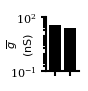

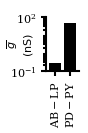

In [28]:
samples, stats, all_seeds_loaded = viz.load_theta_x_seeds(*selected_ones_1, preparation=preparation)
close_sim = check_if_close_to_obs(stats, xo=xo, min_num_bursts=min_num_bursts, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
successful_samples = samples[close_sim][index_1]
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_synapses(successful_samples, params_to_plot, labels=False, ylim=[0.1, 100], width=0.42, height=0.7, labelpad=-18)
    plt.savefig(PANEL_D12, facecolor='None', transparent=True)
    
samples, stats, all_seeds_loaded = viz.load_theta_x_seeds(*selected_ones_2, preparation=preparation)
close_sim = check_if_close_to_obs(stats, xo=xo, min_num_bursts=min_num_bursts, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
successful_samples = samples[close_sim][index_2]
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_synapses(successful_samples, params_to_plot, ylim=[0.1, 100], width=0.42, height=0.7, labelpad=-18)
    plt.savefig(PANEL_D22, facecolor='None', transparent=True)

### Panel E

In [29]:
allowed_std = 1.

In [30]:
successful_samples_tt = []
all_low_energies = []
for i in range(5):
    for j in range(5):
        for k in range(5):
            stats = viz.load_x_pd(i, j, k, preparation)
            samples, _, _ = viz.load_theta_x_seeds(i, j, k, preparation)
            close_sim = check_if_close_to_obs(stats.to_numpy(), xo=xo, min_num_bursts=min_num_bursts, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
            if np.any(close_sim):
                successful_stats1 = stats[close_sim]
                energy1 = successful_stats1["energies"].to_numpy()/10/1000
                summed_energies_total1 = np.asarray(energy1)
                all_low_energies.append(summed_energies_total1)
                
                successful_samples = samples[close_sim]
                successful_samples_tt.append(torch.as_tensor(successful_samples, dtype=torch.float32))
                successful_seeds = all_seeds_loaded[close_sim]

successful_samples_tt = torch.cat(successful_samples_tt)
all_low_energies = np.concatenate(all_low_energies)

In [31]:
successful_samples_tt.shape

torch.Size([290, 31])

### Verify that, for the two remaining ones we can also find a good config

In [32]:
# allowed_std_2 = 1.5

# for i in [0]:
#     for j in [3, 4]:
#         for k in [2]:
#             stats = viz.load_x_pd_correction(i, j, k, preparation)
#             samples, _, _ = viz.load_theta_x_seeds_correction(i, j, k, preparation)
#             close_sim = check_if_close_to_obs(stats.to_numpy(), xo=xo, min_num_bursts=min_num_bursts, sloppiness_durations=allowed_std_2, sloppiness_phases=allowed_std_2)
#             print("config", i, j, k, "close_sim", np.sum(close_sim))

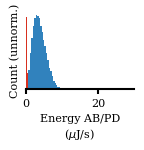

In [33]:
theta = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl")
x = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl")
seeds = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy")

theta_np = theta.to_numpy()
x_np = x.to_numpy()

all_total_energies = x["energies"].to_numpy()
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1))
    _ = ax.hist(all_total_energies[:, 0]/10/1000, range=[0, 30], bins=75, color="#3182bd", weights=0.075*np.ones_like(summed_energies_total))
    _ = ax.hist(all_low_energies[:, 0], range=[0, 30], bins=75, color="#d7301f")
    ax.set_ylabel('Count (unnorm.)')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel("Energy AB/PD\n($\mu$J/s)")
    ax.set_xlim([0, 30])
    plt.savefig(PANEL_E1, facecolor='None', transparent=True)

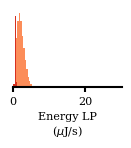

In [34]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1))
    _ = ax.hist(all_total_energies[:, 1]/10/1000, range=[0, 30], bins=75, color="#fc8d59", weights=0.044*np.ones_like(summed_energies_total))
    _ = ax.hist(all_low_energies[:, 1], range=[0, 30], bins=75, color="#d7301f")
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel("Energy LP\n($\mu$J/s)")
    ax.set_xlim([0, 30])
    plt.savefig(PANEL_E2, facecolor='None', transparent=True)

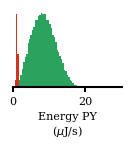

In [35]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1))
    _ = ax.hist(all_total_energies[:, 2]/10/1000, range=[0, 30], bins=75, color="#2ca25f", weights=0.115*np.ones_like(summed_energies_total))
    _ = ax.hist(all_low_energies[:, 2], range=[0, 30], bins=75, color="#d7301f")
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel("Energy PY\n($\mu$J/s)")
    ax.set_xlim([0, 30])
    plt.savefig(PANEL_E3, facecolor='None', transparent=True)

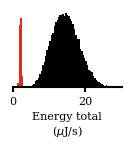

In [36]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1))
    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=75, color="k", weights=0.1*np.ones_like(summed_energies_total))
    _ = ax.hist(np.sum(all_low_energies, axis=1), range=[0, 30], bins=75, color="#d7301f")
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel("Energy total\n($\mu$J/s)")
    ax.set_xlim([0, 30])
    plt.savefig(PANEL_E4, facecolor='None', transparent=True)

### Panel F

In [37]:
prior_samples = prior.sample((100_000,))
xo_full = np.load("../../../results/experimental_data/xo_11deg.npy")
log_probs = posterior.log_prob(torch.as_tensor(theta_np), x=xo_full).numpy()
probs_of_successful = posterior.log_prob(successful_samples_tt, x=xo_full).numpy()
prior_probs = posterior.log_prob(prior_samples, x=xo_full).numpy()

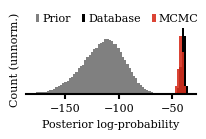

In [38]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 0.9))
    ax.hist(prior_probs, color="grey", bins=70, weights=0.026*np.ones_like(prior_probs), range=(-180, -35))
    ax.hist(log_probs, color="k", bins=70, weights=0.0095*np.ones_like(log_probs), range=(-180, -35))
    ax.hist(probs_of_successful, color="#d7301f", bins=70, range=(-180, -35), alpha=0.9)
    ax.set_xlabel("Posterior log-probability")
    ax.set_ylabel("Count (unnorm.)")
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.legend(["Prior", "Database", "MCMC"], ncol=3, handlelength=0.3, handletextpad=0.3, columnspacing=1.0, loc="upper left", bbox_to_anchor=(0.0, 1.3))
    plt.savefig(PANEL_F, facecolor='None', transparent=True)

# Assemble figure

In [5]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [6]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "9.2cm",
           
    Panel(
        SVG(PANEL_A1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("a", -2.0*factor_svg, 3.8*factor_svg-dshift, **kwargs_text),
    ).move(2.2*factor_svg, -1.5*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_A2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(1*factor_svg, 11.4*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_A3).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(1*factor_svg, 24.3*factor_svg+dshift),
    
    Panel(
        SVG("../svg/panel_a.svg").scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -1.0*factor_svg, 0.55*factor_svg-dshift, **kwargs_text),
    ).move(28.5*factor_svg, 1.75*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("c", 0.5*factor_svg, 4.3*factor_svg-dshift, **kwargs_text),
    ).move(71*factor_svg, -2.0*factor_svg+dshift),
    
    Panel(
        SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(71*factor_svg, 15.5*factor_svg+dshift),
    
    Panel(
        SVG(PANEL_D11).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -1.5*factor_svg, 1.3*factor_svg-dshift, **kwargs_text),
    ).move(104.5*factor_svg, 1.0*factor_svg+dshift),

    Panel(
        SVG(PANEL_D21).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(104.5*factor_svg, 18.0*factor_svg+dshift),
    
    Panel(
        SVG(PANEL_D12).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(126.2*factor_svg, 0.8*factor_svg+dshift),
    Panel(
        SVG(PANEL_D22).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(126.2*factor_svg, 17.8*factor_svg+dshift),
    
    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("e", -0.8*factor_svg, 0.9*factor_svg-dshift, **kwargs_text),
    ).move(1*factor_svg, 40.7*factor_svg),
    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(27.4*factor_svg, 41.0*factor_svg),
    Panel(
          SVG(PANEL_E3).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(51.8*factor_svg, 41.0*factor_svg),
    Panel(
          SVG(PANEL_E4).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(76.3*factor_svg, 41.0*factor_svg),
    
    Panel(
          SVG(PANEL_F).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("f", -11.5*factor_svg, 1.9*factor_svg-dshift, **kwargs_text),
    ).move(114.5*factor_svg, 39.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig5.svg")
svg('../fig/fig5.svg')